## Imports

In [1]:
import sys
import os
import argparse
import time
import random
import math
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt

import torch
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tfs

from tensorboardX import SummaryWriter


from utils import kNN, AverageMeter, py_softmax

In [2]:
# model_name = "VGG"
# magic_dim = 2048

model_name = "ResNet"
magic_dim = 512

In [78]:
dataset_name = "PenDigits"

## Training parameters

In [4]:
#data
datadir = "/root/data/Multivariate_ts"

# optimization
lamb = 10      # SK lambda-parameter
nopts = 400    # number of SK-optimizations
epochs = 30   # numbers of epochs
momentum = 0.9 # sgd momentum
exp = './resnet1d_exp' # experiments results dir


# other
devc='0'  # cuda device
batch_size = 500
lr=0.003     #learning rate
alr=0.03    #starting learning rate

knn_dim = 10
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [5]:
device = torch.device('cuda:' + devc) if torch.cuda.is_available() else torch.device('cpu')
print(f"GPU device: {torch.cuda.current_device()}")

GPU device: 0


## Data Preparation

In [6]:
import pandas as pd
import numpy as np
from scipy.io import arff
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sktime.utils.load_data import load_from_tsfile_to_dataframe

from tqdm import tqdm
import os
from datetime import datetime

In [7]:
def features_to_torch(X):
    X = X.applymap(np.array)
    dimensions_lst = []

    for dim in X.columns:
        dimensions_lst.append(np.dstack(list(X[dim].values))[0])

    dimensions_lst = np.array(dimensions_lst)
    X = torch.from_numpy(np.array(dimensions_lst, dtype=np.float64))
    X = X.transpose(0, 2)
    X = X.transpose(1, 2)
    X = F.normalize(X, dim=1)
    return X.float()

def answers_to_torch(y):
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    y = torch.from_numpy(np.array(y, dtype=np.int32))
    y = y.long()
    return y

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt], excerpt

In [8]:
X_train, y_train = load_from_tsfile_to_dataframe(datadir + f'/{dataset_name}/{dataset_name}_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(datadir + f'/{dataset_name}/{dataset_name}_TEST.ts')

X_train = features_to_torch(X_train)
X_test = features_to_torch(X_test)

y_train = answers_to_torch(y_train)
y_test = answers_to_torch(y_test)

In [9]:
N = X_train.shape[0]
time_steps = X_train.shape[2]
dims_num = X_train.shape[1]
num_classes = len(np.unique(y_train))

print('time_steps:', time_steps)
print('train samples_num:', N)
print('dims_num:', dims_num)
print('num_classes:', num_classes)

time_steps: 8
train samples_num: 7494
dims_num: 2
num_classes: 10


## Model parameters (AlexNet in that case)

In [10]:
hc=10                 # number of heads
ncl=num_classes       # number of clusters

numc = [ncl] * hc
# # (number of filters, kernel size, stride, pad) for AlexNet, two vesions
# CFG = {
#     'big': [(96, 11, 4, 2), 'M', (256, 5, 1, 2), 'M', (384, 3, 1, 1), (384, 3, 1, 1), (256, 3, 1, 1), 'M'],
#     'small': [(64, 11, 4, 2), 'M', (192, 5, 1, 2), 'M', (384, 3, 1, 1), (256, 3, 1, 1), (256, 3, 1, 1), 'M']
# }

## Models

### ResNet

In [11]:
__all__ = ['resnetv1','resnetv1_18']

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class Normalize(nn.Module):
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, in_channel=3, width=1, num_classes=[1000]):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.headcount = len(num_classes)
        self.base = int(16 * width)
        self.features = nn.Sequential(*[                                                     # [100, 8, 18]
                            nn.Conv1d(in_channel, 16, kernel_size=3, padding=1, bias=False), # [100, 16, 36]
                            nn.BatchNorm1d(16),
                            nn.ReLU(inplace=True),
                            self._make_layer(block, self.base, layers[0]),                   # [100, 16, 36]
                            self._make_layer(block, self.base * 2, layers[1]),               # [100, 32, 36]
                            self._make_layer(block, self.base * 4, layers[2]),               # [100, 64, 36]
                            self._make_layer(block, self.base * 8, layers[3]),               # [100, 128, 36]
                            nn.AvgPool1d(2),                                                 # [100, 128, 18]
        ])
    
        if len(num_classes) == 1:
            self.top_layer = nn.Sequential(nn.Linear(magic_dim, num_classes[0]))
        else:
            for a, i in enumerate(num_classes):
                setattr(self, "top_layer%d" % a, nn.Linear(magic_dim, i))
            self.top_layer = None
        for m in self.features.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x.float())
        out = out.view(out.size(0), -1)
        if self.headcount == 1:
            if self.top_layer:
                out = self.top_layer(out)
            return out
        else:
            outp = []
            for i in range(self.headcount):
                outp.append(getattr(self, "top_layer%d" % i)(out))
            return outp

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

def resnetv1_18(num_classes=[1000]):
    """Encoder for instance discrimination and MoCo"""
    return resnet18(num_classes=num_classes)

### VGG

In [12]:
class VGG(nn.Module):
    def __init__(self, num_classes):
        super(VGG, self).__init__()
        self.headcount = len(num_classes)
        
        self.features = nn.Sequential(*[                                                     # [100, 8, 18]
                            nn.Conv1d(dims_num, 64, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
#                             nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
#                             nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
#                             nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
#                             nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

#                             nn.Flatten(),
#                             nn.Linear(in_features=512 * (time_steps // 2**5), out_features=fc_hidden_dim, bias=True),

#                             nn.ReLU(inplace=True),
#                             nn.Dropout(p=0.5, inplace=False),
#                             nn.Linear(in_features=fc_hidden_dim, out_features=fc_hidden_dim, bias=True),
#                             nn.ReLU(inplace=True),
#                             nn.Dropout(p=0.5, inplace=False),
#                             nn.Linear(in_features=fc_hidden_dim, out_features=num_classes, bias=True),
#                             nn.Softmax()
        ])
        
        if len(num_classes) == 1:
            self.top_layer = nn.Sequential(nn.Linear(magic_dim, num_classes[0]))
        else:
            for a, i in enumerate(num_classes):
                setattr(self, "top_layer%d" % a, nn.Linear(magic_dim, i))
            self.top_layer = None
    
    def forward(self, x):
        out = self.features(x.float())  # [50, 10, 400] -> [50, 512, 12]
        out = out.view(out.size(0), -1) # [50, magic_dim]
        if self.headcount == 1:
            if self.top_layer:
                out = self.top_layer(out)
                print (out.size())
            return out
        else:
            outp = []
            for i in range(self.headcount):
                outp.append(getattr(self, "top_layer%d" % i)(out))
            return outp

## Sinkhorn-Knopp optimization

In [13]:
def optimize_L_sk(PS):
    N, K = PS.shape
    tt = time.time()
    PS = PS.T  # now it is K x N
    r = np.ones((K, 1)) / K
    c = np.ones((N, 1)) / N
    PS **= lamb  # K x N
    inv_K = 1. / K
    inv_N = 1. / N
    err = 1e3
    _counter = 0
    while err > 1e-2:
        r = inv_K / (PS @ c)  # (KxN)@(N,1) = K x 1
        c_new = inv_N / (r.T @ PS).T  # ((1,K)@(KxN)).t() = N x 1
        if _counter % 10 == 0:
            err = np.nansum(np.abs(c / c_new - 1))
        c = c_new
        _counter += 1
        
    print("error: ", err, 'step ', _counter, flush=True)  # " nonneg: ", sum(I), flush=True)
    # inplace calculations.
    PS *= np.squeeze(c)
    PS = PS.T
    PS *= np.squeeze(r)
    PS = PS.T
    argmaxes = np.nanargmax(PS, 0)  # size N
    newL = torch.LongTensor(argmaxes)
    selflabels = newL.to(device)
    PS = PS.T
    PS /= np.squeeze(r)
    PS = PS.T
    PS /= np.squeeze(c)
    sol = PS[argmaxes, np.arange(N)]
    np.log(sol, sol)
    cost = -(1. / lamb) * np.nansum(sol) / N
    print('cost: ', cost, flush=True)
    print('opt took {0:.2f}min, {1:4d}iters'.format(((time.time() - tt) / 60.), _counter), flush=True)
    return cost, selflabels

def opt_sk(model, selflabels_in, epoch):
    if hc == 1:
        PS = np.zeros((N, ncl))
    else:
        PS_pre = np.zeros((N, magic_dim)) # knn_dim
    
    for batch_idx, (data, _, _selected) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
        data = data.to(device)#cuda()
        if hc == 1:
            p = nn.functional.softmax(model(data), 1)
            PS[_selected, :] = p.detach().cpu().numpy()
        else:
            p = model(data.float())
            PS_pre[_selected, :] = p.detach().cpu().numpy() # p: [20, magic_dim]
    if hc == 1:
        cost, selflabels = optimize_L_sk(PS)
        _costs = [cost]
    else:
        _nmis = np.zeros(hc)
        _costs = np.zeros(hc)
        nh = epoch % hc  # np.random.randint(args.hc)
        print("computing head %s " % nh, end="\r", flush=True)
        tl = getattr(model, "top_layer%d" % nh)
        # do the forward pass:
        PS = (PS_pre @ tl.weight.cpu().numpy().T
                   + tl.bias.cpu().numpy())
        PS = py_softmax(PS, 1)
        c, selflabels_ = optimize_L_sk(PS)
        _costs[nh] = c
        selflabels_in[nh] = selflabels_
        selflabels = selflabels_in
    return selflabels

## Training utils

In [14]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = alr
    if epochs == 200:
        if epoch >= 80:
            lr = alr * (0.1 ** ((epoch - 80) // 40))  # i.e. 120, 160
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 400:
        if epoch >= 160:
            lr = alr * (0.1 ** ((epoch - 160) // 80))  # i.e. 240,320
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 800:
        if epoch >= 320:
            lr = alr * (0.1 ** ((epoch - 320) // 160))  # i.e. 480, 640
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 1600:
        if epoch >= 640:
            lr = alr * (0.1 ** ((epoch - 640) // 320))
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [15]:
def feature_return_switch(model, bool=True):
    """
    switch between network output or conv5features
        if True: changes switch s.t. forward pass returns post-conv5 features
        if False: changes switch s.t. forward will give full network output
    """
    if bool:
        model.headcount = 1
    else:
        model.headcount = hc
    model.return_feature = bool

In [16]:
def train(epoch, selflabels):
    print('\nEpoch: %d' % epoch)
    print(model_name)
    adjust_learning_rate(optimizer, epoch)
    train_loss = AverageMeter()
    data_time = AverageMeter()
    batch_time = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    
    for batch_idx, (inputs, targets, indexes) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
        inputs = inputs.float().to(device)
        niter = epoch * N // batch_size + batch_idx
        if niter * batch_size >= optimize_times[-1]:
            with torch.no_grad():
                _ = optimize_times.pop()
                if hc >1:
                    feature_return_switch(model, True)
                selflabels = opt_sk(model, selflabels, epoch)
                if hc >1:
                    feature_return_switch(model, False)
        data_time.update(time.time() - end)
        inputs, targets = inputs.to(device), targets.to(device)#, indexes.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        if hc == 1:
            loss = criterion(outputs, selflabels[indexes])
        else:
            loss = torch.mean(torch.stack([criterion(outputs[h], selflabels[h, indexes]) for h in range(hc)]))

        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
#         if True:
        if batch_idx % 10 == 0:
            print('Epoch: [{}][{}/{}]'
                  'Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) '
                  'Data: {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Loss: {train_loss.val:.4f} ({train_loss.avg:.4f})'.format(
                epoch, batch_idx, N // batch_size, batch_time=batch_time, data_time=data_time, train_loss=train_loss))
#             writer.add_scalar("loss", loss.item(), batch_idx*512 +epoch*N/batch_size)
    return selflabels

In [86]:
def plot_acc(acc, model_name, dataset_name):
    step = 3
    x = np.arange(1, epochs//step)
    acc = acc[::step]
    plt.plot(x*step, acc[1:])
    plt.xlabel("# epoch")
    plt.ylabel("Accuracy, %")
    plt.grid(True)
    plt.title(f"Train accuracy, self-labeling, {model_name}, {dataset_name}")

## Model initialization

In [18]:
if model_name == "ResNet":
    model = resnet18(num_classes=numc, in_channel=dims_num)
else:
    model = VGG(num_classes=numc)
print (model_name, "created")

ResNet created


In [19]:
optimize_times = ((epochs + 1.0001)*N*(np.linspace(0, 1, nopts))[::-1]).tolist()
optimize_times = [(epochs +10)*N] + optimize_times
print('We will optimize L at epochs:', [np.round(1.0*t/N, 2) for t in optimize_times], flush=True)

We will optimize L at epochs: [40.0, 31.0, 30.92, 30.84, 30.77, 30.69, 30.61, 30.53, 30.46, 30.38, 30.3, 30.22, 30.15, 30.07, 29.99, 29.91, 29.83, 29.76, 29.68, 29.6, 29.52, 29.45, 29.37, 29.29, 29.21, 29.14, 29.06, 28.98, 28.9, 28.82, 28.75, 28.67, 28.59, 28.51, 28.44, 28.36, 28.28, 28.2, 28.13, 28.05, 27.97, 27.89, 27.81, 27.74, 27.66, 27.58, 27.5, 27.43, 27.35, 27.27, 27.19, 27.12, 27.04, 26.96, 26.88, 26.8, 26.73, 26.65, 26.57, 26.49, 26.42, 26.34, 26.26, 26.18, 26.11, 26.03, 25.95, 25.87, 25.79, 25.72, 25.64, 25.56, 25.48, 25.41, 25.33, 25.25, 25.17, 25.1, 25.02, 24.94, 24.86, 24.78, 24.71, 24.63, 24.55, 24.47, 24.4, 24.32, 24.24, 24.16, 24.09, 24.01, 23.93, 23.85, 23.77, 23.7, 23.62, 23.54, 23.46, 23.39, 23.31, 23.23, 23.15, 23.08, 23.0, 22.92, 22.84, 22.76, 22.69, 22.61, 22.53, 22.45, 22.38, 22.3, 22.22, 22.14, 22.07, 21.99, 21.91, 21.83, 21.75, 21.68, 21.6, 21.52, 21.44, 21.37, 21.29, 21.21, 21.13, 21.06, 20.98, 20.9, 20.82, 20.74, 20.67, 20.59, 20.51, 20.43, 20.36, 20.28, 20.2

In [20]:
# init selflabels randomly
if hc == 1:
    selflabels = np.zeros(N, dtype=np.int32)
    for qq in range(N):
        selflabels[qq] = qq % ncl
    selflabels = np.random.permutation(selflabels)
    selflabels = torch.LongTensor(selflabels).to(device)
else:
    selflabels = np.zeros((hc, N), dtype=np.int32)
    for nh in range(hc):
        for _i in range(N):
            selflabels[nh, _i] = _i % numc[nh]
        selflabels[nh] = np.random.permutation(selflabels[nh])
    selflabels = torch.LongTensor(selflabels).to(device)

In [21]:
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

In [22]:
writer = SummaryWriter(f'./runs/{dataset_name}')

## Training! 
Takes a couple of minutes per epoch

In [23]:
def my_kNN(net, K, sigma=0.1, dim=128, use_pca=False):
    net.eval()
    # this part is ugly but made to be backwards-compatible. there was a change in cifar dataset's structure.
    trainLabels = y_train
    LEN = N
    C = trainLabels.max() + 1

    trainFeatures = torch.zeros((magic_dim, LEN))  # , device='cuda:0') # dim
    normalize = Normalize()
    for batch_idx, (inputs, targets, _) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=False)):
        batchSize = batch_size
        inputs = inputs.cuda()
        features = net(inputs.float())
        if not use_pca:
            features = normalize(features)
        trainFeatures[:, batch_idx * batchSize:batch_idx * batchSize + batchSize] = features.data.t().cpu()
        
    if use_pca:
        comps = 4
        print('doing PCA with %s components'%comps, end=' ')
        from sklearn.decomposition import PCA
        pca = PCA(n_components=comps, whiten=False)
        trainFeatures = pca.fit_transform(trainFeatures.numpy().T)
        trainFeatures = torch.Tensor(trainFeatures)
        trainFeatures = normalize(trainFeatures).t()
        print('..done')
    def eval_k_s(K_,sigma_):
        total = 0
        top1 = 0.
        top5 = 0.

        with torch.no_grad():
            retrieval_one_hot = torch.zeros(K_, C)# .cuda()
            for batch_idx, (inputs, targets, _) in enumerate(iterate_minibatches(X_test, y_test, batch_size, shuffle=False)):
                targets = targets # .cuda(async=True) # or without async for py3.7
                inputs = inputs.cuda()
                batchSize = batch_size
                features = net(inputs)
                if use_pca:
                    features = pca.transform(features.cpu().numpy())
                    features = torch.Tensor(features).cuda()
                features = normalize(features).cpu()

                dist = torch.mm(features, trainFeatures)

                yd, yi = dist.topk(K_, dim=1, largest=True, sorted=True)
                candidates = trainLabels.view(1, -1).expand(batchSize, -1)
                retrieval = torch.gather(candidates, 1, yi).long()

                retrieval_one_hot.resize_(batchSize * K_, C).zero_()
                retrieval_one_hot.scatter_(1, retrieval.view(-1, 1), 1.)
                
                yd_transform = yd.clone().div_(sigma_).exp_()
                probs = torch.sum(torch.mul(retrieval_one_hot.view(batchSize, -1, C),
                                            yd_transform.view(batchSize, -1, 1)),
                                  1)
                _, predictions = probs.sort(1, True)

                # Find which predictions match the target
                correct = predictions.eq(targets.data.view(-1, 1))

                top1 = top1 + correct.narrow(1, 0, 1).sum().item()
                top5 = top5 + correct.narrow(1, 0, 5).sum().item()

                total += targets.size(0)

        print(f"{K_}-NN,s={sigma_}: TOP1: ", top1 * 100. / total)
        return top1 / total

    if isinstance(K, list):
        res = []
        for K_ in K:
            for sigma_ in sigma:
                res.append(eval_k_s(K_, sigma_))
        return res
    else:
        res = eval_k_s(K, sigma)
        return res

In [24]:
accuracies = []
best_accuracies = []
start = time.time()

for epoch in range(start_epoch, start_epoch + epochs):
    selflabels = train(epoch, selflabels)
    feature_return_switch(model, True)
    
    acc = my_kNN(model, K=10, sigma=0.1, dim=knn_dim)
    accuracies.append(acc)
    feature_return_switch(model, False)
#     writer.add_scalar("accuracy kNN", acc, epoch)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'opt': optimizer.state_dict(),
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/best_ckpt.t7' % (exp))
        best_acc = acc
        best_accuracies.append(best_acc)
    if epoch % 100 == 0:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'opt': optimizer.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/ep%s.t7' % (exp, epoch))
    if epoch % 50 == 0:
        feature_return_switch(model, True)
        acc = my_kNN(model, K=[50, 10], sigma=[0.1, 0.5], dim=knn_dim, use_pca=True)
        i = 0
#         for num_nn in [50, 10]:
#             for sig in [0.1, 0.5]:
#                 writer.add_scalar('knn%s-%s' % (num_nn, sig), acc[i], epoch)
#                 i += 1
        feature_return_switch(model, False)
    print('best accuracy: {:.2f}'.format(best_acc * 100))
end = time.time()

# checkpoint = torch.load('%s'%exp+'/best_ckpt.t7' )
# model.load_state_dict(checkpoint['net'])
feature_return_switch(model, True)
acc = my_kNN(model, K=10, sigma=0.1, dim=knn_dim, use_pca=True)


Epoch: 0
ResNet
error:  0.0015402576511577282 step  31
cost:  1.8896547803967036
opt took 0.00min,   31iters
Epoch: [0][0/14]Time: 0.230 (0.230) Data: 0.173 (0.173) Loss: 2.4584 (2.4584)
error:  0.0016104083665109403 step  61
cost:  1.8365955556674802
opt took 0.00min,   61iters
error:  0.008056123587746766 step  91
cost:  1.5750405927300593
opt took 0.00min,   91iters
error:  0.006358236716571208 step  121
cost:  1.4240073279621797
opt took 0.00min,  121iters
error:  0.007512972465985812 step  151
cost:  1.3470586206896116
opt took 0.00min,  151iters
error:  0.006630689788855171 step  221
cost:  1.221907366958299
opt took 0.00min,  221iters
error:  0.008118809904080981 step  231
cost:  1.1065262640548637
opt took 0.00min,  231iters
error:  0.00803001570873818 step  281
cost:  0.9172640080038702
opt took 0.00min,  281iters
error:  0.008560528916061738 step  331
cost:  0.847633897199281
opt took 0.00min,  331iters
Epoch: [0][10/14]Time: 0.206 (0.176) Data: 0.172 (0.136) Loss: 2.2402 (2

error:  0.009815548290130538 step  471
cost:  0.3779006738770209
opt took 0.00min,  471iters
error:  0.009023440140412897 step  541
cost:  0.36502972219669255
opt took 0.00min,  541iters
10-NN,s=0.1: TOP1:  87.23333333333333
best accuracy: 88.10

Epoch: 6
ResNet
error:  0.00047410357041277607 step  31
cost:  1.8751417984979326
opt took 0.00min,   31iters
Epoch: [6][0/14]Time: 0.157 (0.157) Data: 0.122 (0.122) Loss: 1.1424 (1.1424)
error:  0.006137594072491148 step  41
cost:  1.7617272236053385
opt took 0.00min,   41iters
error:  0.0090668397724466 step  81
cost:  1.540698915373771
opt took 0.00min,   81iters
error:  0.008436420083275054 step  151
cost:  1.2725807430819285
opt took 0.00min,  151iters
error:  0.00670792516021157 step  221
cost:  1.0157037708366765
opt took 0.00min,  221iters
error:  0.009900704015983752 step  371
cost:  0.7977301761715049
opt took 0.00min,  371iters
error:  0.008618449976986908 step  421
cost:  0.6456220908332306
opt took 0.00min,  421iters
error:  0.008

error:  0.009334939234804662 step  461
cost:  0.3005855998022735
opt took 0.00min,  461iters
error:  0.009651428851832455 step  1091
cost:  0.28262392589933294
opt took 0.00min, 1091iters
error:  0.009651774189521678 step  1621
cost:  0.2845826032418224
opt took 0.00min, 1621iters
Epoch: [11][10/14]Time: 0.486 (0.384) Data: 0.451 (0.341) Loss: 0.3752 (0.3801)
error:  0.00919404986774941 step  1121
cost:  0.2614444169892552
opt took 0.00min, 1121iters
error:  0.009753590645148358 step  2561
cost:  0.25033998037236876
opt took 0.01min, 2561iters
10-NN,s=0.1: TOP1:  87.13333333333334
best accuracy: 88.10

Epoch: 12
ResNet
error:  0.009843093245213708 step  3511
cost:  0.282603310760049
opt took 0.01min, 3511iters
Epoch: [12][0/14]Time: 0.938 (0.938) Data: 0.903 (0.903) Loss: 0.3909 (0.3909)
error:  0.009695907462070052 step  2651
cost:  0.276437821383517
opt took 0.01min, 2651iters
error:  0.00998208823634028 step  2051
cost:  0.27010424684484075
opt took 0.01min, 2051iters
error:  0.0095

error:  0.009769697577486691 step  2051
cost:  0.23497085153254632
opt took 0.01min, 2051iters
error:  0.009930377549683289 step  2451
cost:  0.24214350494624615
opt took 0.01min, 2451iters
error:  0.0095363931954775 step  1511
cost:  0.24340782032248998
opt took 0.00min, 1511iters
error:  0.00980062981266483 step  2171
cost:  0.24649737215426676
opt took 0.01min, 2171iters
error:  0.00960111775500061 step  2041
cost:  0.25065192854174495
opt took 0.01min, 2041iters
error:  0.009296552035512051 step  431
cost:  0.27331257523283997
opt took 0.00min,  431iters
error:  0.006611453195326966 step  201
cost:  0.2631664878021427
opt took 0.00min,  201iters
Epoch: [17][10/14]Time: 0.206 (0.452) Data: 0.160 (0.411) Loss: 0.3267 (0.3314)
error:  0.007251284542859282 step  201
cost:  0.24841016354670808
opt took 0.00min,  201iters
error:  0.007921198184410172 step  221
cost:  0.2403153199611405
opt took 0.00min,  221iters
error:  0.009608685195056199 step  361
cost:  0.2409122055740641
opt took 0

error:  0.00937385277760705 step  781
cost:  0.24025037775269265
opt took 0.00min,  781iters
Epoch: [23][0/14]Time: 0.313 (0.313) Data: 0.278 (0.278) Loss: 0.3044 (0.3044)
error: ng head 3  0.008554640595128338 step  341
cost:  0.22648681738341586
opt took 0.00min,  341iters
error:  0.009107851437501924 step  711
cost:  0.21758890011607987
opt took 0.00min,  711iters
error:  0.008582865802251649 step  491
cost:  0.21560757959935137
opt took 0.00min,  491iters
error:  0.009753639331395725 step  631
cost:  0.22164299925168443
opt took 0.00min,  631iters
error:  0.009263129717764329 step  491
cost:  0.23184888452510155
opt took 0.00min,  491iters
error:  0.009477243328378404 step  281
cost:  0.2451827372521696
opt took 0.00min,  281iters
error:  0.008205255083984397 step  421
cost:  0.24540416352735894
opt took 0.00min,  421iters
error:  0.009511147845525758 step  541
cost:  0.2371298310554669
opt took 0.00min,  541iters
error:  0.00985816671428108 step  931
cost:  0.23730323617991747
opt

cost:  0.23728395099435723
opt took 0.00min,  701iters
Epoch: [28][10/14]Time: 0.251 (0.253) Data: 0.214 (0.212) Loss: 0.2653 (0.2804)
error:  0.008978889410409918 step  621
cost:  0.23624904967090807
opt took 0.00min,  621iters
error:  0.009033281661146142 step  721
cost:  0.24077084501835844
opt took 0.00min,  721iters
10-NN,s=0.1: TOP1:  86.96666666666667
best accuracy: 88.10

Epoch: 29
ResNet
error:  0.008426057317733604 step  341
cost:  0.24854625125527768
opt took 0.00min,  341iters
Epoch: [29][0/14]Time: 0.246 (0.246) Data: 0.210 (0.210) Loss: 0.2758 (0.2758)
error:  0.007665200918131387 step  271
cost:  0.2631346163158891
opt took 0.00min,  271iters
error:  0.008676117360015834 step  481
cost:  0.2745491310705156
opt took 0.00min,  481iters
error:  0.00986286404382175 step  471
cost:  0.26087774192904345
opt took 0.00min,  471iters
error:  g head 9 0.008917355798661819 step  281
cost:  0.23588946771514616
opt took 0.00min,  281iters
error:  0.008107707334780612 step  341
cost: 

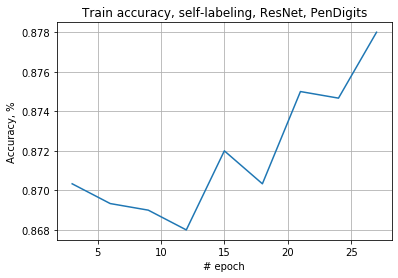

In [79]:
plot_acc(accuracies, model_name, dataset_name);

In [80]:
print ("Self-labeling")
print ("-------------------------")
print ("Model:     ", model_name)
print ("Dataset:   ", dataset_name)
print ("Epochs:    ", epochs)
print ("lr:        ", lr)
print ("Batch size:", batch_size)
print ("Heads:     ", hc)
print ("Time:      ", end-start)
print ("Best acc:  ", best_acc*100)

Self-labeling
-------------------------
Model:      ResNet
Dataset:    PenDigits
Epochs:     30
lr:         0.003
Batch size: 500
Heads:      10
Time:       137.36616945266724
Best acc:   88.1
